In [38]:
import recognition_helper as helper
import pandas as pd
import numpy as np
import cv2

In [2]:
helper.r.ping()

True

In [ ]:
## step 1: extract data from database

In [39]:
hash_name = 'school:register'

In [40]:
decoded_dictionary = helper.r.hgetall(name='school:register')
decoded_series = pd.Series(decoded_dictionary)
decoded_series
# Convert each element of retrive_series from bytes to 32-bit float NumPy arrays
decoded_series = decoded_series.apply(lambda x: np.frombuffer(x, dtype=np.float32))

# Retrieve the index of retrive_series
index = decoded_series.index

# Convert the index elements from bytes to strings
index = list(map(lambda x: x.decode(), index))
decoded_series.index = index
decoded_df = decoded_series.to_frame().reset_index()
decoded_df.columns = ['name_role', 'facial_features']
decoded_df.rename(columns={'facial_features':'Facial Features'}, inplace= True)
# Split by '#' and create a new DataFrame with two columns 'Name' and 'Role'
temp_df = decoded_df['name_role'].str.split('#', expand=True)

# Split each part by '_' and capitalize each word
decoded_df[['Name', 'Role']] = temp_df.applymap(lambda x: ' '.join([word.capitalize() for word in x.split('_')]))

decoded_df



C:\Users\user\AppData\Local\Temp\ipykernel_4120\2292138186.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  decoded_df[['Name', 'Role']] = temp_df.applymap(lambda x: ' '.join([word.capitalize() for word in x.split('_')]))


,name_role,Facial Features,Name,Role
0,Niral#Student,"[-0.97980136, -0.3088756, 0.062451832, -0.8709...",Niral,Student
1,Anshu#Student,"[-0.47274327, -0.5457361, 0.36073217, 0.004857...",Anshu,Student
2,Shreyash#Student,"[0.6344553, -0.6053782, -0.047888815, 0.051233...",Shreyash,Student
3,Shruti#Student,"[-0.11612214, -0.2465572, -0.031031808, 1.6600...",Shruti,Student
4,Piyush#Student,"[-0.8362277, 0.8302344, -0.9622365, -1.3610224...",Piyush,Student
5,Harsh#Student,"[0.35201174, -0.39142653, 0.13513993, 0.286284...",Harsh,Student


In [22]:
## Get Realtime prediction

In [41]:
import cv2
import time
from datetime import datetime
from keras.models import load_model
from openpyxl import Workbook, load_workbook
from scipy.spatial import distance as dist

emotion_model = load_model('emotion_model.h5')
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Function to calculate eye aspect ratio (EAR)
def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear


In [69]:
# define a video capture object 
vid = cv2.VideoCapture(0) 

# Load face and eye cascade classifiers
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
# gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# faces = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml').detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

# Initialize variables
start_time = time.time()
last_active_time = time.time()
distraction_threshold = 5  # in seconds
distracted = False

now = datetime.now()
excel_file = 'user_data_' + now.strftime("%d_%m_%Y_%H_%M_%S") + '.xlsx'
wb = Workbook()
sheet = wb.active
sheet.append(["Name", "Timestamp", "Distracted", "Emotion", "Face Data"])

while(True): 
    decoded_df
       
    # Capture the video frame by frame 
    ret, frame = vid.read() 
    
    if ret == False:
        print("Unable to read camera")
        break
    
    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:

        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (48, 48))
        face = face.astype('float32') / 255.0
        face = np.expand_dims(face, axis=0)
        face = np.expand_dims(face, axis=-1)
        
        emotion_prediction = emotion_model.predict(face)
        max_index = np.argmax(emotion_prediction[0])
        emotion = emotion_labels[max_index]
        
        person_name = helper.name_prediction(frame, decoded_df)
        text_color = (0,255,0) if person_name != 'Unknown' else (0,0,255)
        
        # Draw rectangle around detected face
        person_data = f"Name: {person_name}\nEmotion: {emotion}"
        person_data = person_data.split('\n')

        for i, person_data in enumerate(person_data):
            cv2.putText(frame, person_data , (x, (y-20) + i*15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color)

        cv2.rectangle(frame, (x, y), (x + w, y + h), text_color, 2)

        # Extract region of interest (ROI) for eyes
        roi_gray = gray[y:y + h, x:x + w]
        roi_color = frame[y:y + h, x:x + w]

        # Detect eyes within the face region
        eyes = eye_cascade.detectMultiScale(roi_gray)

        # Calculate attentiveness based on eye aspect ratio (EAR)
        attentiveness = 0
        for (ex, ey, ew, eh) in eyes:
            eye = roi_gray[ey:ey + eh, ex:ex + ew]
            ear = eye_aspect_ratio(eye)
            attentiveness += ear

        # Normalize attentiveness by the number of eyes
        if len(eyes) > 0:
            attentiveness /= len(eyes)

        # Check if the user is distracted
        if attentiveness < 0.25:  # Example threshold for closed eyes
            if time.time() - last_active_time > distraction_threshold:
                distracted = True
        else:
            distracted = False

        if person_name != 'Unknown':
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            sheet.append([person_name, timestamp, distracted, emotion, str(frame)])
        
    if len(faces) < 1 and person_name != 'Unknown':
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        sheet.append([person_name, timestamp, True, "", "[]"])
        
    cv2.imshow('prediction_frame', frame) 
    
    # the 'q' button is set as the 
    # quitting button you may use any 
    # desired button of your choice 
    if cv2.waitKey(1) == ord('q'): 
        break
  
wb.save(excel_file)
# After the loop release the cap object 
vid.release() 
# Destroy all the windows 
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

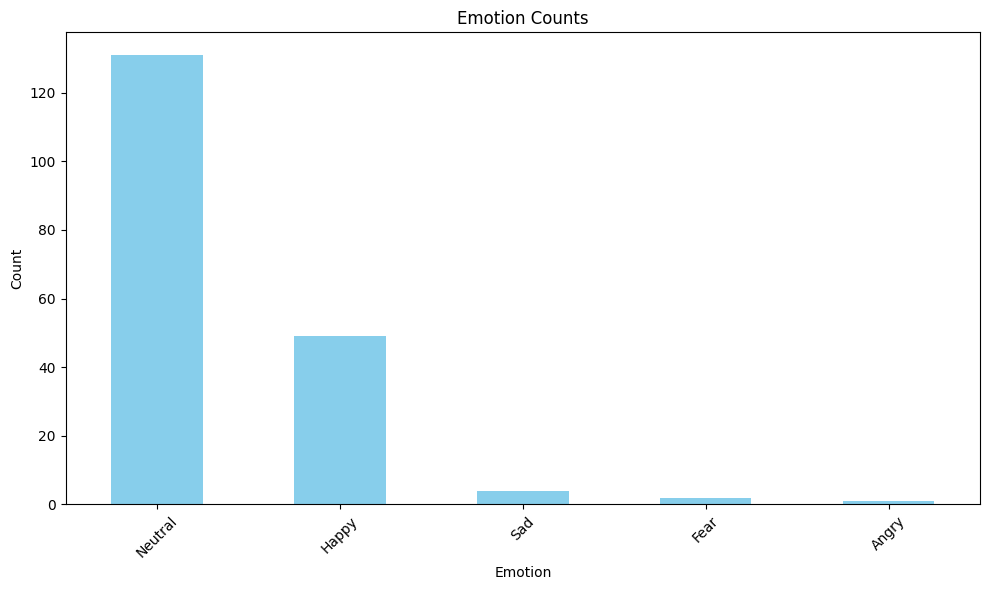

In [65]:
import matplotlib.pyplot as plt
df = pd.read_excel(excel_file)

# Generate a bar chart of emotion counts
emotion_counts = df['Emotion'].value_counts()
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Emotion Counts')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

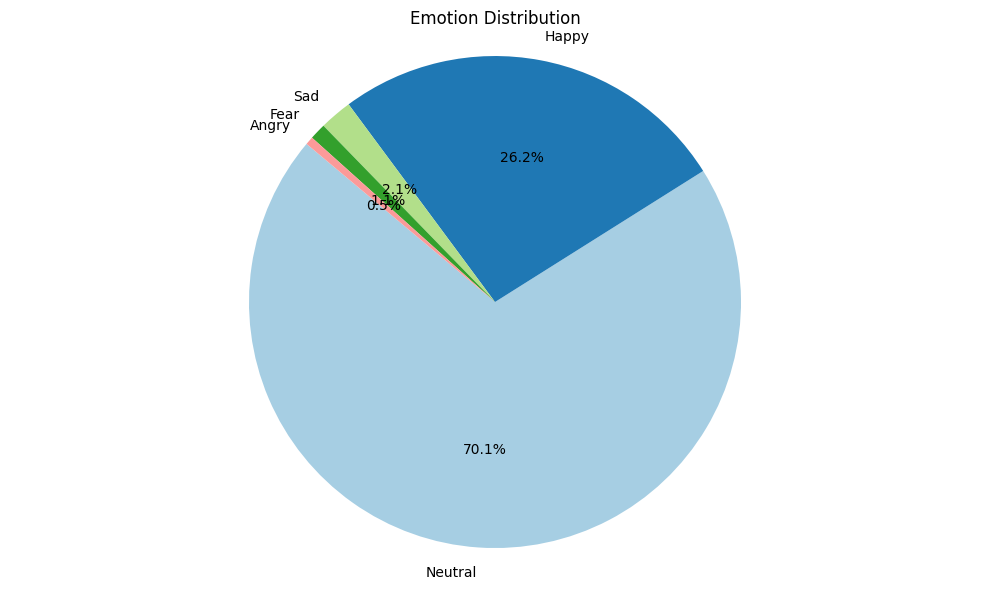

In [66]:
emotion_counts = df['Emotion'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(emotion_counts))))
plt.title('Emotion Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.savefig('emotion_distribution.png')
plt.show()

In [61]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
from email.utils import formataddr

    # Your email and app password
sender_email = "shreyubanawala@gmail.com"
sender_name = "Automatic Alert"
sender_password = "wqhd sbgs qokq bfdb"
recipient_email = "banawalashreyash@gmail.com"

# Create message
msg = MIMEMultipart()
msg["From"] = formataddr((sender_name, sender_email))
msg['To'] = recipient_email
msg['Subject'] = "Emotion Detection Alert"
body = f"Hi {person_name},\n\nHope you are doing well, file below contains the data of your last class.\n\n\nThank you"
msg.attach(MIMEText(body, 'plain'))

attachment = MIMEBase("application", "octet-stream")
with open(excel_file, "rb") as file:
    attachment.set_payload(file.read())
encoders.encode_base64(attachment)
attachment.add_header(
    "Content-Disposition",
    f"attachment; filename= {excel_file}",
)
msg.attach(attachment)

# Send email
try:
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(sender_email, sender_password)
    text = msg.as_string()
    server.sendmail(sender_email, recipient_email, text)
    server.quit()
    print("Email sent successfully")
except Exception as e:
    print(f"Error: {str(e)}")

Email sent successfully


In [ ]:
def name_prediction(self, image, df):
    # Step 1: find date time
    # Load face and eye cascade classifiers
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    current_time = str(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

    # step 2: take image and apply insightface model
    image_information = app_sc.get(image)
    image_copy = image.copy()

    start_time = time.time()
    last_active_time = time.time()
    distraction_threshold = 5  # in seconds
    distracted = False

    now = datetime.now()
    excel_file = 'user_data_' + now.strftime("%d_%m_%Y_%H_%M_%S") + '.xlsx'
    wb = Workbook()
    sheet = wb.active
    sheet.append(["Name", "Timestamp", "Distracted", "Emotion", "Face Data"])

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    # print(image_information)

    # step 3: we can use loop to get data of every person and to manipulate the input image
    # eg draw rectangle around recognized  person's face
    type(image_information)
    df.head()
    for (x, y, w, h) in faces:

        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (48, 48))
        face = face.astype('float32') / 255.0
        face = np.expand_dims(face, axis=0)
        face = np.expand_dims(face, axis=-1)
        
        emotion_prediction = emotion_model.predict(face)
        max_index = np.argmax(emotion_prediction[0])
        emotion = emotion_labels[max_index]
        
        person_name = helper.name_prediction(frame, decoded_df)
        text_color = (0,255,0) if person_name != 'Unknown' else (0,0,255)
        
        # Draw rectangle around detected face
        person_data = f"Name: {person_name}\nEmotion: {emotion}"
        person_data = person_data.split('\n')

        for i, person_data in enumerate(person_data):
            cv2.putText(image_copy, person_data , (x, (y-20) + i*15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color)

        cv2.rectangle(image_copy, (x, y), (x + w, y + h), text_color, 2)

        # Extract region of interest (ROI) for eyes
        roi_gray = gray[y:y + h, x:x + w]
        roi_color = image_copy[y:y + h, x:x + w]

        # Detect eyes within the face region
        eyes = eye_cascade.detectMultiScale(roi_gray)

        # Calculate attentiveness based on eye aspect ratio (EAR)
        attentiveness = 0
        for (ex, ey, ew, eh) in eyes:
            eye = roi_gray[ey:ey + eh, ex:ex + ew]
            ear = eye_aspect_ratio(eye)
            attentiveness += ear

        # Normalize attentiveness by the number of eyes
        if len(eyes) > 0:
            attentiveness /= len(eyes)

        # Check if the user is distracted
        if attentiveness < 0.25:  # Example threshold for closed eyes
            if time.time() - last_active_time > distraction_threshold:
                distracted = True
        else:
            distracted = False

        if person_name != 'Unknown':
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            sheet.append([person_name, timestamp, distracted, emotion, str(frame)])
        
    if len(faces) < 1 and person_name != 'Unknown':
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        ws.append([person_name, timestamp, True, "", "[]"])

    # save data to class level 'data_dict' dictionary
    self.data_dict['name'].append(person_name)
    self.data_dict['role'].append(role)
    self.data_dict['current_time'].append(current_time)
    return image_copy

In [6]:
# # define a video capture object 
# vid = cv2.VideoCapture(0) 
# while(True): 
#     decoded_df
       
#     # Capture the video frame by frame 
#     ret, frame = vid.read() 
    
#     if ret == False:
#         print("Unable to read camera")
#         break
    
#     predicted_frame = helper.name_prediction(frame, decoded_df)
    
#     # Display the resulting frame 
# #     cv2.imshow('frame', frame) 
#      # Display the predict frame 
#     cv2.imshow('prediction_frame', predicted_frame) 
    
#     # the 'q' button is set as the 
#     # quitting button you may use any 
#     # desired button of your choice 
#     if cv2.waitKey(1) == ord('i'): 
#         break
  
# # After the loop release the cap object 
# vid.release() 
# # Destroy all the windows 
# cv2.destroyAllWindows()